# Определение возраста покупателей

В нашем распоряжении датасет с набором фотографий с указанием возвраста. Необходимо построить модель, которая определит приблизительный возраст человека по фотографии его лица.

Подключим библиотеки

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
sns.set(style="darkgrid")

In [3]:
SEED = 66

## Исследовательский анализ данных

Загрузим данные и проведём их осмотр (создадим сразу ImageDataGenerator)

In [4]:
df = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(dataframe=df, 
                                                   directory='/datasets/faces/final_files/',
                                                   x_col='file_name', 
                                                   y_col='real_age', 
                                                   target_size=(224, 224), 
                                                   batch_size=16, 
                                                   class_mode='raw', 
                                                   seed=SEED)

Found 7591 validated image filenames.


Выведем случайные данные

In [5]:
df.sample(n=10, random_state=SEED)

,file_name,real_age
399,000399.jpg,26
6751,006758.jpg,16
7260,007278.jpg,35
4302,004302.jpg,35
2746,002746.jpg,48
418,000418.jpg,9
3534,003534.jpg,21
5001,005001.jpg,26
2350,002350.jpg,5
3887,003887.jpg,19


Данные загружены. По содержимому: есть имя файла и возраст человека на ней

In [6]:
print('Данных:', df.shape[0])

Данных: 7591


У нас 7591 запись. При работе с датасетом мы будет использовать 25% от него для валидации, а 75% для обучения

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
file_name    7591 non-null object
real_age     7591 non-null int64
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


Пропусков нет

In [8]:
df.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


Посмотрим на распределение по возрасту на графике

[Text(0.5, 0, 'Возраст'), Text(0.5, 1.0, 'Распределение ворастов')]

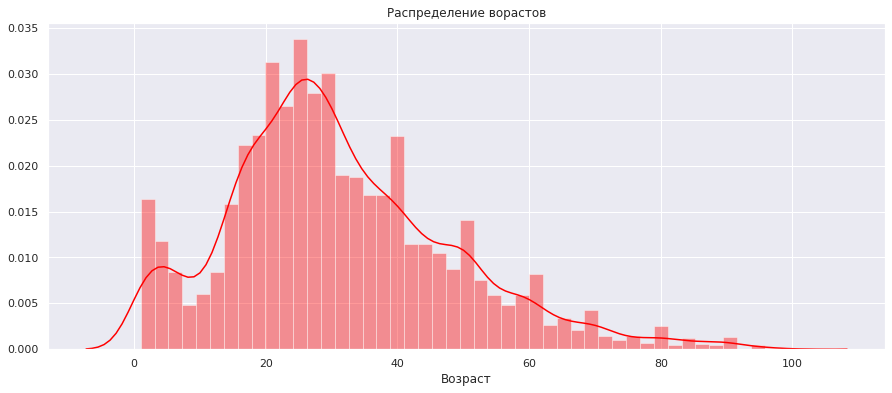

In [9]:
fig = plt.figure(figsize=(15,6))
ax = sns.distplot(df['real_age'], color='red')
ax.set(title='Распределение ворастов', xlabel='Возраст')

Больше всего людей в возрасте от 16 до 40 лет. Меньше всего от 80 до 100<br>
Можно отметить момент, что есть "пики" в значенияъ, кратных 10 лет(20, 30, 40, 50 и т.д.). Возможно, это связано с системой разметки данных. Или же точный возраст был неизвестен и указан был применый<br>
Посмотрим на фотографии

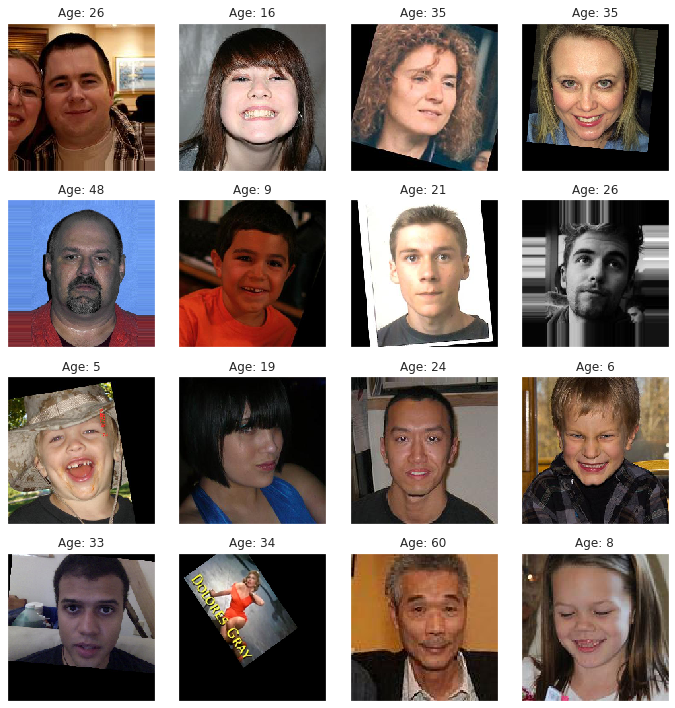

In [10]:
features, target = next(train_gen_flow)

fig = plt.figure(figsize=(10,10))
for i in range(16):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.title('Age: ' + str(target[i]))

В выборке достаточно разнообразные изображения<br>
Есть мужчины, женщины, дети, все разных возрастов. Также есть чёрно белые фотографии и не "портретные" фотографии (например, инжний ряд, вторая фотография)

Модель будем использовать ResNet50, с ипользование весов imagenet

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

def load_train(path):
    labels = pd.read_csv(path + 'labels.csv')
    train_datagen = ImageDataGenerator(validation_split=0.25, 
                                       horizontal_flip=True, 
                                       rescale=1./255)
    train_gen_flow = train_datagen.flow_from_dataframe(dataframe=labels, 
                                                       directory=path + 'final_files/', 
                                                       x_col='file_name', 
                                                       y_col='real_age', 
                                                       target_size=(224, 224), 
                                                       batch_size=16, 
                                                       class_mode='raw',
                                                       subset='training', 
                                                       seed=12345)
    return train_gen_flow

def load_test(path):
    labels = pd.read_csv(path + 'labels.csv')
    test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    test_gen_flow = test_datagen.flow_from_dataframe(dataframe=labels, 
                                                     directory=path + 'final_files/',
                                                     x_col='file_name', 
                                                     y_col='real_age',
                                                     target_size=(224, 224), 
                                                     batch_size=16, 
                                                     class_mode='raw',
                                                     subset='validation', 
                                                     seed=12345)
    return test_gen_flow

def create_model(input_shape):
    backbone = ResNet50(weights='imagenet', input_shape=input_shape, include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    optimizer = Adam(lr=0.0005)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data, validation_data=test_data, 
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch, 
              validation_steps=validation_steps, 
              verbose=2)

    return model

```

```
Found 5694 validated image filenames.
Found 1897 validated image filenames.
<class 'tensorflow.python.keras.engine.sequential.Sequential'>
Train for 356 steps, validate for 119 steps
Epoch 1/20
356/356 - 116s - loss: 195.4988 - mae: 10.6055 - val_loss: 300.0466 - val_mae: 12.9098
Epoch 2/20
356/356 - 39s - loss: 136.8007 - mae: 8.8858 - val_loss: 217.2968 - val_mae: 11.3695
Epoch 3/20
356/356 - 39s - loss: 110.9723 - mae: 8.0122 - val_loss: 273.2212 - val_mae: 12.3131
Epoch 4/20
356/356 - 39s - loss: 98.3872 - mae: 7.5834 - val_loss: 125.0150 - val_mae: 8.4376
Epoch 5/20
356/356 - 39s - loss: 84.1067 - mae: 6.9916 - val_loss: 107.9474 - val_mae: 8.0568
Epoch 6/20
356/356 - 39s - loss: 68.5070 - mae: 6.3377 - val_loss: 106.6528 - val_mae: 7.8515
Epoch 7/20
356/356 - 39s - loss: 58.9232 - mae: 5.9470 - val_loss: 88.0706 - val_mae: 7.1134
Epoch 8/20
356/356 - 39s - loss: 47.8026 - mae: 5.3104 - val_loss: 107.1394 - val_mae: 7.7615
Epoch 9/20
356/356 - 39s - loss: 39.4431 - mae: 4.8654 - val_loss: 98.5204 - val_mae: 7.5479
Epoch 10/20
356/356 - 39s - loss: 41.4038 - mae: 4.9618 - val_loss: 138.9959 - val_mae: 8.3586
Epoch 11/20
356/356 - 39s - loss: 34.2701 - mae: 4.5101 - val_loss: 103.2221 - val_mae: 7.5376
Epoch 12/20
356/356 - 39s - loss: 31.3585 - mae: 4.3017 - val_loss: 84.7699 - val_mae: 7.0716
Epoch 13/20
356/356 - 39s - loss: 27.4470 - mae: 4.0247 - val_loss: 145.1598 - val_mae: 9.6830
Epoch 14/20
356/356 - 39s - loss: 23.5663 - mae: 3.7769 - val_loss: 84.2124 - val_mae: 7.0117
Epoch 15/20
356/356 - 39s - loss: 20.5696 - mae: 3.4730 - val_loss: 85.3703 - val_mae: 7.0610
Epoch 16/20
356/356 - 39s - loss: 20.7611 - mae: 3.4868 - val_loss: 84.1839 - val_mae: 6.8745
Epoch 17/20
356/356 - 39s - loss: 18.4887 - mae: 3.3283 - val_loss: 84.2319 - val_mae: 6.8739
Epoch 18/20
356/356 - 39s - loss: 17.5988 - mae: 3.2186 - val_loss: 94.9607 - val_mae: 7.2576
Epoch 19/20
356/356 - 39s - loss: 17.9542 - mae: 3.2463 - val_loss: 91.2803 - val_mae: 7.2164
Epoch 20/20
356/356 - 39s - loss: 24.8086 - mae: 3.7366 - val_loss: 90.8101 - val_mae: 7.3627
119/119 - 10s - loss: 90.8101 - mae: 7.3627
Test MAE: 7.3627
```

## Анализ обученной модели

Мы обучили модель ResNet50<br>
Полученная модель предсказвыает возраст человека по фотографии со средней ошибкой 7.3 года, что удовлетворяет заданию (не больше 8)